# Predicting Disaster Tweets with Recurrent Neural Networks

## Introduction

Twitter has become an important mode of communication for emergencies. However, not all announcements made anyone and everyone are actually disasters. An example given is the word "ABLAZE." This word can be used by a person to mean something metaphorically but a computer will have a hard time understanding what it really means in context.

In this project, our goal is to predict whether a tweet is about a real natural distaster or not. If yes, we'd predict 1. Otherwise we'd predict 0.

We'll be comparing several model architectures to see which one would give us the best predictive performance. The distilBERT model is a low-code wrapper of tensorflow suitable for text classification class. We'll compare that to recurrent neural network (RNN) architectures. There are two types we'll be using: Long Short-Term Memory and Gate Reccurent Unit. Because we are handling sequential data, RNN's are very suitbale for this task. RNN's can also handle variable length input and capture relationships overall a temporal scale which are what we need fo this natural language preocessing task. Both LSTM and GRU architectures are ideal for dealing with exploding/vanishing gradients. We'll finally tuned our LSTM model and make predicitons on the test set.

## About the data

The dataset includes a training, testing a submission comma seperated values (.csv) files.
Each sample in the train and test set has a text of a tweet, a keyword from tweet, and location the tweet was sent from.
Column names incude: 
1. id- a unique identifier
2. text- text of the tweet
3. location- where tweet was sent from
4. keyword- keyword from tweet
5. target- train.csv has whether tweet is about a real disaster or not (1, or 0)

Furthur dataset description can be found in the Kaggle competition page https://www.kaggle.com/competitions/nlp-getting-started/data.

## Project Overview:
1. Setting Up Environment

   Import modules such as sklearn and tensorflow for our project. We will be using the computer's GPU for training.
   
2. Exploratory Data Analysis (EDA)
   
   View summary statistics of datasets. View basic summary statistics as check for missing values and duplicates
   
3. Data Preprocessing
   
   Fill in missing values and drop cruplicates. 
   
   Combine text columns
   
   Defining Training/Validation Sets
   
   Word pprocessing  tokenization
   
4. Model Architecture 1: DistilBERT with Ktrain
    
   Utilize low code wrapper to Tensorflow for text claddification
   
   Model Evaluation. Assessing loss and accuracy for our metrics of performance.
    
4. Model Architecture 2: LSTM

   Train model using Tensorflow Keras Long Short-Term Memory (LSTM)
   
   Evaluate model for loss and accuracy

5. Model Architecture 3: GRU

   Train model using Tensorflow Keras Gated Reccurrent Unit (RGU)
   
   Evaluate model for loss and accuracy
    
6. Hyperparameter tuning and building upon LSTM Model
   
   Decrease epochs and adjust early stopping parameters
   
   Increasing number of layers
   
   Add bidrectional layer for prcossing inputs both forwards and backwards
   
   Adding normalization layer for training stability and improving training time
   
   Adding additional dropout layers for reducing overfitting
   
   Once hypearameters are tuned to desired, model is compiled and trained
   
   Evaluate loss of train vs validation and accuracy score. 

8. Predict on Test dataset for submission

   Make prediction using best model and submit for evualtion in Kaggle
    
9. Discussion/ Summary

   Reflect on the work, discuss results and what can be improved

## Setting up the environment

Import libraries and modules needed for the project. These include modules for displaying graphical outputs, performance metrics, proccessing texts, and model-building packages such sklearn, tensorflow and keras.

In [220]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
##Suppress warnings
warnings.filterwarnings("ignore")
# from PIL import Image
# import cv2
import ktrain
import spacy
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer,TFBertModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample, shuffle
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score
from torchvision import transforms
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Embedding, LSTM, GRU, TextVectorization, Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.backend import clear_session
import keras_nlp
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adagrad, Adam, Nadam
##print("keras version=", keras_nlp.__version__)

In [2]:
##download the english model for spaCy and load it
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
##stopwords
nltk.download('punkt')
nltk.download('stopwords')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kcsle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kcsle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Create a base directory path so that reading files and folders from the directory is easier:

In [3]:
current_directory = os.getcwd()
##convert forward slashes to backslashes
work_dir = current_directory.replace('\\', '/')
##print("Working Base Directory:", work_dir)

Using Deep learning with Tensor will require intensive computational resources. Therefore, make decrease the time for our model training, we will mount GPU from my system.

In [4]:
##Suppress warnings
warnings.filterwarnings("ignore")
##Check avaiablibility og GPU
print("\nGPU Available:", tf.test.is_gpu_available())
##Check GPU device name
print(tf.test.gpu_device_name())
##Check CUDA Toolkit and cuDNN installation
print("\nCUDA Toolkit Version:", tf.test.is_built_with_cuda())
##Check tensorflow version. This version should have GPU capbilityCheck TensorFlow installation
print("\nInstalled TensorFlow Version:", tf.__version__)


GPU Available: True
/device:GPU:0

CUDA Toolkit Version: True

Installed TensorFlow Version: 2.10.1


In [5]:
##Set and use the GPU
GPU = tf.config.experimental.list_physical_devices('GPU')
if GPU:
    tf.config.experimental.set_visible_devices(GPU[0], 'GPU')
    tf.config.experimental.set_memory_growth(GPU[0], True)
    print("GPU will be used.")
else:
    print("No GPU mounted, using CPU...")

GPU will be used.


## Exploratory data Analysis (EDA)

Here, we'll read the training, testing and submission data. We will view the shape/ data attributes as well as do some basic summary statistics and visualizations such as look for missing data or duplicates.

In [6]:
##First read the datasets traina and test
train_df = pd.read_csv(work_dir+"/Documents/MS DS coursework/Intro to Deep Learning/Week 4/train.csv")
test_df = pd.read_csv(work_dir+"/Documents/MS DS coursework/Intro to Deep Learning/Week 4/test.csv")
samp_df = pd.read_csv(work_dir+"/Documents/MS DS coursework/Intro to Deep Learning/Week 4/sample_submission.csv")

In [7]:
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
##View shape train
train_df.shape

(7613, 5)

In [9]:
test_df.shape

(3263, 4)

In [10]:
test_df.head(5) 

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
##Data types. Test data is same withoout target column
train_df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [12]:
nas = train_df['text'].isna().sum()
print("Number of Na's 'text' col=", nas)

Number of Na's 'text' col= 0


In [13]:
##Count duplicates in column text
dups = train_df['text'].duplicated().sum()
print("Number of duplicates 'text' col=", dups)

Number of duplicates 'text' col= 110


In [14]:
kws = train_df['keyword'].isna().sum()
print("Number of keywords missing=", kws)

Number of keywords missing= 61


[Text(0, 0, 'Non-disaster'), Text(1, 0, 'Disaster')]

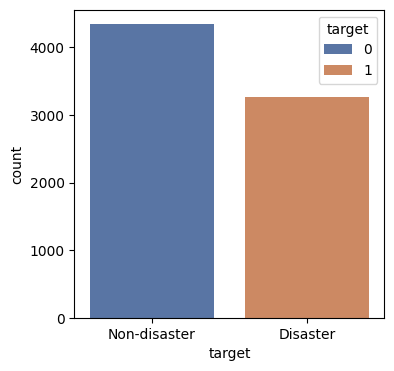

In [15]:
plt.figure(figsize=(4, 4))
dis_plot = sns.countplot(x='target', hue='target', data=train_df, palette="deep")
dis_plot.set_xticks([0, 1])
dis_plot.set_xticklabels(['Non-disaster','Disaster'])

## Data Preprocessing

Now we are ready to prepare out data. We will do the following:

1. Clean up the data
2. Perform text preprocessing
3. Balance the binary dataset
4. Split our dataset set into training and validation sets
5. Tokenize and vectorize out texts from the training, validation and testing sets

First, let's drop all duplicate text rows because it is not easy to tell what the target is actually for the given text. 

In [16]:
train_df = train_df.drop_duplicates(subset = "text", keep = False)

Since keywords might be important and can help with the predictions, we will combine it with the text column in a column called "comb_text" and use it in the analysis.

In [17]:
train_df['keyword'].fillna('',inplace=True)
train_df['comb_text'] = train_df['text'] + ' ' + train_df['keyword']

In [18]:
##check shape again
train_df.shape

(7434, 6)

Here is an important step for Natural Language Processing. We'll put together a function for performing text processing including changin words to lowercase, removing punctuation, removing numerics, tokenizing the words and removing stop words. We will includ options for advanced preprocessing of text including lemmatization and stemming.

In [19]:
def text_prep(text, adv_proc= ["none","lemma","stem"]):
    ## to lowercase
    text = text.lower()
    ## remove punctuation
    text= re.sub(r'[^\w\s]', '', text)
    ## remove numerics
    text = re.sub(r'\d+', '', text)
    ## tokenization
    words = word_tokenize(text)
    ## remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]

    ##Use lemma, steming or none
    if adv_proc is "lemma":
        ##lemma using spacy
        words = [token.lemma_ for token in nlp(" ".join(words))]
    elif adv_proc is "stem":
        ##Stemming using NLTK's Porter Stemmer
        stemm = PorterStemmer()
        words = [stemm.stem(word) for word in words]
    else:
        ##None lemma or stam advanced processings
        words
        
    ##join words into string
    proc_text = ' '.join(words)
    
    # ## tokenization
    # words = word_tokenize(proc_text)
    return words

In [20]:
##check example
input_text = "Use example of 1 sentence of disaster! tweet"
proc_text = text_prep(input_text, adv_proc= "none")
proc_text_lemma = text_prep(input_text, adv_proc= "none")
proc_text_stem = text_prep(input_text, adv_proc="stem")

print("original:", proc_text)
print("lemmatization:", proc_text_lemma)
print("stemming:", proc_text_stem)

original: ['use', 'example', 'sentence', 'disaster', 'tweet']
lemmatization: ['use', 'example', 'sentence', 'disaster', 'tweet']
stemming: ['use', 'exampl', 'sentenc', 'disast', 'tweet']


In [21]:
train_df["text_len"] = train_df["comb_text"].apply(lambda x : len(x))
print(train_df["text_len"].describe())

count    7434.000000
mean      110.441620
std        34.581695
min         9.000000
25%        86.000000
50%       116.000000
75%       142.000000
max       164.000000
Name: text_len, dtype: float64


<Axes: xlabel='text_len', ylabel='Count'>

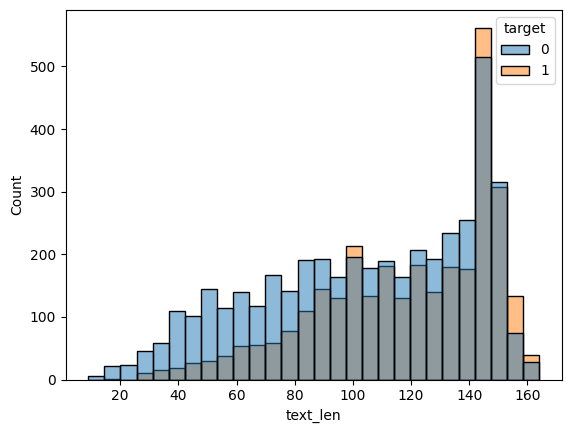

In [22]:
sns.histplot(x="text_len", hue= "target", data= train_df)

In [23]:
test_df['keyword'].fillna('',inplace=True)
test_df['comb_text'] = test_df['text'] + ' ' + test_df['keyword']
test_df["text_len"] = test_df["comb_text"].apply(lambda x : len(x))
test_df["full_text"] = test_df["comb_text"].apply(lambda x : text_prep(x, adv_proc= "none"))
print(test_df["text_len"].describe())

count    3263.000000
mean      111.951885
std        34.718777
min         9.000000
25%        88.000000
50%       120.000000
75%       143.000000
max       171.000000
Name: text_len, dtype: float64


In [24]:
train_df.describe()

,id,target,text_len
count,7434.000000,7434.000000,7434.000000
mean,5445.289615,0.423729,110.441620
std,3144.093523,0.494182,34.581695
min,1.000000,0.000000,9.000000
25%,2729.250000,0.000000,86.000000
50%,5414.500000,0.000000,116.000000
75%,8161.750000,1.000000,142.000000
max,10873.000000,1.000000,164.000000


In [25]:
train_df["full_text"] = train_df["comb_text"].apply(lambda x : text_prep(x, adv_proc= "none"))

In [26]:
train_df.head()

,id,keyword,location,text,target,comb_text,text_len,full_text
0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,70,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,39,"[forest, fire, near, la, ronge, sask, canada]"
2,5,,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,134,"[residents, asked, shelter, place, notified, o..."
3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",66,"[people, receive, wildfires, evacuation, order..."
4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,89,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


Now we will get our dataset ready for model training by splitting the training data into training and validation sets. This will be important for out LSTM, GRU and Tuned LSTM models.

[Text(0, 0, 'Non-disaster'), Text(1, 0, 'Disaster')]

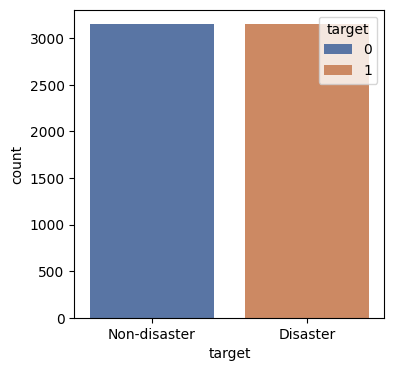

In [27]:
##Set random state
rs= 123
##lowest count for postive values. 
##use at much of the data as possible to balance the training dataset
samp_size= len(train_df[train_df['target']==1])

train_0= train_df[train_df['target']==0].sample(samp_size, random_state=rs)
train_1= train_df[train_df['target']==1].sample(samp_size, random_state=rs)

concat_dat= pd.concat([train_0, train_1], axis= 0).reset_index(drop=True)
train_df= shuffle(concat_dat)

plt.figure(figsize=(4, 4))
newtrain_plot = sns.countplot(x='target', hue='target', data= train_df, palette="deep")
newtrain_plot.set_xticks([0, 1])
newtrain_plot.set_xticklabels(['Non-disaster','Disaster'])


In [28]:
texts = train_df['full_text']
labels = train_df['target']
rs= 123
X_train, X_val, y_train, y_val = train_test_split(texts,
                                              labels,
                                              test_size=0.15,
                                              random_state=rs,shuffle=True)
texts.head()
# labels.head()

4974    [cant, fix, stupid, mt, cbccalgary, dont, driv...
3215    [heat, wave, squad, revitup, pizzarev, httptco...
5463    [pagasa, yellow, warning, panay, island, guima...
2597    [cant, believe, myfriendmina, photo, bombed, s...
2037    [feel, engulfed, low, selfimage, take, quiz, h...
Name: full_text, dtype: object

Finally tokenize our word sequences and use vectorization to convert text to numeric representation and prep for RNN models

In [29]:
# vocab_size = 1000
max_len = 30
##make sure to account for out of vocabulary words
tokenizer = Tokenizer(num_words = len(train_df), oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)

seq_train = tokenizer.texts_to_sequences(X_train)
X_train_vect = pad_sequences(seq_train,maxlen=max_len)

seq_val = tokenizer.texts_to_sequences(X_val)
X_val_vect = pad_sequences(seq_val,maxlen=max_len)

seq_test = tokenizer.texts_to_sequences(test_df["full_text"])
X_test_vect = pad_sequences(seq_test,maxlen=max_len)

X_train_vect
X_val_vect
X_test_vect

array([[   0,    0,    0, ..., 1980,   73,   17],
       [   0,    0,    0, ...,  589, 1455,  236],
       [   0,    0,    0, ...,  859,  630,  407],
       ...,
       [   0,    0,    0, ...,  621,  118, 1130],
       [   0,    0,    0, ...,  211, 1397, 1576],
       [   0,    0,    0, ..., 1100,    9,  292]])

## Model Architecture 1: DistilBERT with Ktrain

DistilBERT is a lightweight version of BERT (Bidriectional Encorder Representations from Transformers), that compared to BERT, is more memory-efficient as well as faster while maintaining equivalent performance compared to BERT model.

The advantage of this model is that it is a container that has a lot of existing pre-trained vocabulary to work off from.

Our process is as follows:
1. Sample 1000 rows of text data from 0 and 1 target to balance the data. 
    The rows of data are also memory-effienct (not too high for memory usage and not too low for training the model).
2. Get texts from dataframe using ktrain to get traning, validation and prepocess sets.
    max features of 10000 means important words up to 10000 are used.
    max length up to 100 means any sequence of words above 100 are truncated while below that are padded.
    Validation precent is 20%.
    n gram range means we are using sets of two words.
3. Get the classifier and learner rate.
4. Use best saved model to make predictions on validation set 
5. Evaluate the loss and prediction of the model

In [39]:
sample_amount = 1000
rs= 123
dis = train_df[train_df['target'] == 1].sample(n=sample_amount, random_state=rs)
non_dis = train_df[train_df['target'] == 0].sample(n=sample_amount, random_state=rs)

In [40]:
part_df = pd.concat([dis,non_dis])
part_df.describe()

,id,target,text_len
count,2000.000000,2000.000000,2000.000000
mean,5445.462000,0.500000,111.419000
std,3161.745416,0.500125,33.718258
min,1.000000,0.000000,17.000000
25%,2594.000000,0.000000,88.000000
50%,5481.500000,0.500000,117.000000
75%,8176.250000,1.000000,142.000000
max,10864.000000,1.000000,164.000000


In [41]:
train, val, preprocess = ktrain.text.texts_from_df(
    part_df,
    "comb_text",
    label_columns=["target"],
    val_df=None,
    max_features=10000,
    maxlen=100,
    val_pct=0.20,
    ngram_range=2,
    preprocess_mode="distilbert",
    verbose=1
)

['not_target', 'target']
      not_target  target
1349         1.0     0.0
2297         1.0     0.0
5609         0.0     1.0
1062         1.0     0.0
5350         0.0     1.0
['not_target', 'target']
      not_target  target
1355         1.0     0.0
889          1.0     0.0
5165         0.0     1.0
4454         0.0     1.0
5341         0.0     1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 16
	95percentile : 25
	99percentile : 28


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 16
	95percentile : 25
	99percentile : 28


In [42]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=4)

In [43]:
learner.lr_find(max_epochs=4)

simulating training for different learning rates... this may take a few moments...
Epoch 1/4
400/400 [==============================] - 32s 59ms/step - loss: 0.6738 - accuracy: 0.5850
Epoch 2/4
400/400 [==============================] - 24s 60ms/step - loss: 0.6023 - accuracy: 0.6719
Epoch 3/4
400/400 [==============================] - 20s 49ms/step - loss: 5.9676 - accuracy: 0.4815


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


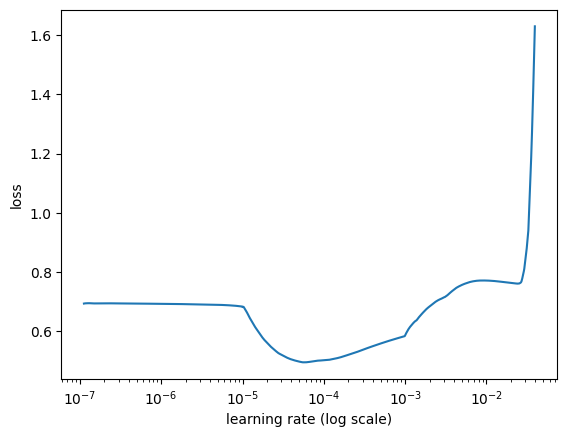

In [44]:
learner.lr_plot()

In [45]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
400/400 [==============================] - 37s 74ms/step - loss: 0.5719 - accuracy: 0.7194 - val_loss: 0.4610 - val_accuracy: 0.8050
Epoch 2/10
400/400 [==============================] - 27s 66ms/step - loss: 0.4216 - accuracy: 0.8263 - val_loss: 0.4947 - val_accuracy: 0.7825
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [46]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [47]:
validation = learner.validate(val_data=val, print_report=True)

13/13 [==============================] - 2s 53ms/step
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       191
           1       0.86      0.75      0.80       209

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.80       400
weighted avg       0.81      0.81      0.80       400



Our distilBERT wrapper model achieved a good prediction accuracy of 0.80 overall. Let's see how this compare to other model architectures LSTM and GRU.

In [205]:
##learner.view_top_losses(n=1, preproc=text.preprocessor)
##Save the best validation accuracy and loss
acc = []
loss = []

acc.append(0.8050)
loss.append(0.4610)

In [49]:
##Clear session of tf
clear_session()

## Model Architecture 2: LSTM

LSTM stand for Long Short-Term Memory is a type or recuurent naural network (RNN) that addressed the vanishining graident prodblem that traditional RNNs have. LTSM consits of a cell, an input gate and an output gate.

Our architecture consists of the following:

1. An Embedding layer cor creating word embeddings. The integer-encoded vocabulary is transformed into a dense vector of output_dim.
2. An LSTM with 128 units and an activaation "relu"
3. A drop out layer of 0.5 for regularization. This is used to reduce overfitting but randonly selecting a portion of input units and set it to 0 for training and introducing noise.
4. A dense layer od 100 units with relu activation for high level feature extraction
5. A dense layer of 1 unit for binary class probability predictions

In [50]:
# Parameters
embedding_dim = 128
vocab_size=4000 
max_len= 30

# input_layer= Input(shape=(1,), dtype='string')
modlstm= Sequential()
# modlstm.add(vectorizer(input_layer))
modlstm.add(Embedding(input_dim= vocab_size,
                      output_dim= embedding_dim, 
                      input_length= max_len))
# modlstm.add(LSTM(100,activation='tanh', return_sequences=False))
# modlstm.add(Dropout(0.2))
modlstm.add(LSTM(128, activation='relu'))
modlstm.add(Dropout(0.5))
modlstm.add(Dense(128, activation='relu'))
modlstm.add(Dense(1, activation='sigmoid'))

##compile the data
optimizers = Adam(learning_rate=0.0001)
# optimizers = Adagrad(learning_rate=0.0001)
modlstm.compile(loss='binary_crossentropy',
                   optimizer=optimizers,
                   metrics=['accuracy'])

##show model summry
modlstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           512000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 660,225
Trainable params: 660,225
Non-trainable params: 0
_________________________________________________________________


In [51]:
early_stop1 = EarlyStopping(monitor='val_loss', 
                           patience=8, 
                           restore_best_weights=True)
model_cp1 = ModelCheckpoint("lstm_bestmod.h5",
                           monitor= 'val_loss',
                           verbose= 1,
                           save_best_only=True)
reduce_lr1 = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              min_lr=0.00001)

In [52]:
num_eps = 30
batches= 32

##Model train
histlstm = modlstm.fit(X_train_vect, 
                       y_train, 
                       batch_size= batches, 
                       epochs= num_eps, 
                       callbacks=[early_stop1, model_cp1, reduce_lr1],
                       validation_data=(X_val_vect, y_val))

Epoch 1/30
168/168 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.5651
Epoch 1: val_loss improved from inf to 0.68712, saving model to lstm_bestmod.h5
168/168 [==============================] - 16s 79ms/step - loss: 0.6916 - accuracy: 0.5651 - val_loss: 0.6871 - val_accuracy: 0.6413 - lr: 1.0000e-04
Epoch 2/30
168/168 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.6607
Epoch 2: val_loss improved from 0.68712 to 0.54002, saving model to lstm_bestmod.h5
168/168 [==============================] - 12s 74ms/step - loss: 0.6531 - accuracy: 0.6607 - val_loss: 0.5400 - val_accuracy: 0.7302 - lr: 1.0000e-04
Epoch 3/30
168/168 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.7796
Epoch 3: val_loss improved from 0.54002 to 0.44240, saving model to lstm_bestmod.h5
168/168 [==============================] - 13s 77ms/step - loss: 0.4792 - accuracy: 0.7796 - val_loss: 0.4424 - val_accuracy: 0.7894 - lr: 1.0000e-04
Epoch 4/30
168

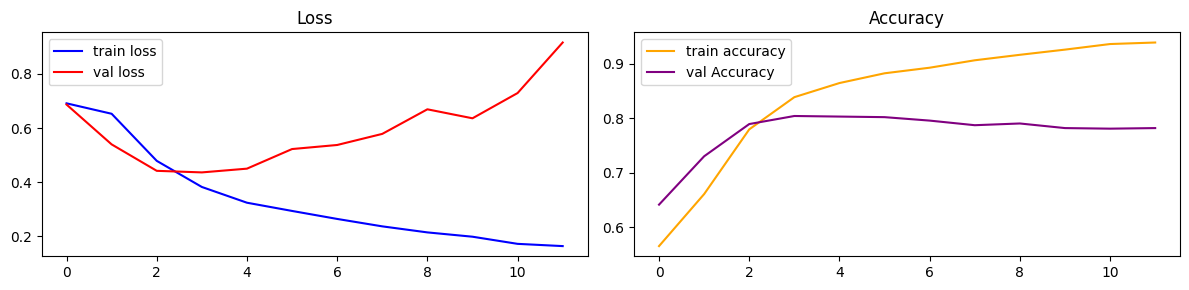

In [53]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
plt.plot(histlstm.history['loss'], label='train loss', color= "blue")
plt.plot(histlstm.history['val_loss'], label='val loss', color="red")
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(histlstm.history['accuracy'], label='train accuracy', color= "orange")
plt.plot(histlstm.history['val_accuracy'], label='val Accuracy', color= "purple")
plt.legend()
plt.title('Accuracy')

# plt.subplot(1, 2, 3)
# plt.plot(modhist.history['auc'], label='train AUC', color= "brown")
# plt.plot(modhist.history['val_auc'], label='val AUC', color= "green")
# plt.legend()
# plt.title('AUC')

plt.tight_layout()
plt.show()

In [206]:
##Save best LSTM model

model_path2= work_dir+'/lstm_bestmod.h5'
loadmod2= load_model(model_path2)
val_loss2, val_acc2 = loadmod2.evaluate(X_val_vect, y_val)
print("Val Accuracy of Best Model=", val_acc2)
acc.append(round(val_acc2,4))
loss.append(round(val_loss2,4))

30/30 [==============================] - 1s 16ms/step - loss: 0.4366 - accuracy: 0.8042
Val Accuracy of Best Model= 0.8042327761650085


In [207]:
acc

[0.805, 0.8042]

In [208]:
loss

[0.461, 0.4366]

## Model Architecture 3: GRU

GRU stands for Gated Reccurrent Unit is a type of recurrent neural network (RNN) that is similar to LSTM but lacks a context vector or output gate. It is also a useful RNN that is effective for modelling sequential dating and addressing the vanishing-exploding gradient problem.

Our architecture is identical to LSTM and consists of the following:

1. An Embedding layer cor creating word embeddings. The integer-encoded vocabulary is transformed into a dense vector of output_dim.
2. An LSTM with 128 units and an activaation "relu"
3. A drop out layer of 0.5 for regularization. This is used to reduce overfitting but randonly selecting a portion of input units and set it to 0 for training and introducing noise.
4. A dense layer od 100 units with relu activation for high level feature extraction
5. A dense layer of 1 unit for binary class probability predictions

In [57]:
# Parameters
embedding_dim = 128
vocab_size=4000 
max_len= 30

gru_mod = Sequential()
gru_mod.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
# gru_mod.add(GRU(units=100, activation='tanh', return_sequences=False))
# gru_mod.add(Dense(units=256, activation='relu'))
gru_mod.add(LSTM(128, activation='relu'))
gru_mod.add(Dropout(0.5))
gru_mod.add(Dense(128, activation='relu'))
gru_mod.add(Dense(units=1, activation='sigmoid'))

##compile the data
optimizers = Adam(learning_rate=0.0001)
# optimizers = Adagrad(learning_rate=0.0001)
gru_mod.compile(loss='binary_crossentropy',
                   optimizer=optimizers,
                   metrics=['accuracy'])

# Display the model summary
gru_mod.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 128)           512000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 660,225
Trainable params: 660,225
Non-trainable params: 0
_________________________________________________________________


In [58]:
early_stop2 = EarlyStopping(monitor='val_loss', 
                           patience=8, 
                           restore_best_weights=True)
model_cp2 = ModelCheckpoint("gru_bestmod.h5",
                           monitor= 'val_loss',
                           verbose= 1,
                           save_best_only=True)
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              min_lr=0.00001)

In [59]:
num_eps = 30
batches= 32

##Model train
histgru = gru_mod.fit(X_train_vect, 
                       y_train, 
                       batch_size= batches, 
                       epochs= num_eps, 
                       callbacks=[early_stop2, model_cp2, reduce_lr2],
                       validation_data=(X_val_vect, y_val))

Epoch 1/30
168/168 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5529
Epoch 1: val_loss improved from inf to 0.68752, saving model to gru_bestmod.h5
168/168 [==============================] - 14s 78ms/step - loss: 0.6918 - accuracy: 0.5529 - val_loss: 0.6875 - val_accuracy: 0.6709 - lr: 1.0000e-04
Epoch 2/30
168/168 [==============================] - ETA: 0s - loss: 0.6596 - accuracy: 0.6495
Epoch 2: val_loss improved from 0.68752 to 0.56346, saving model to gru_bestmod.h5
168/168 [==============================] - 13s 80ms/step - loss: 0.6596 - accuracy: 0.6495 - val_loss: 0.5635 - val_accuracy: 0.7407 - lr: 1.0000e-04
Epoch 3/30
168/168 [==============================] - ETA: 0s - loss: 0.4854 - accuracy: 0.7802
Epoch 3: val_loss improved from 0.56346 to 0.44825, saving model to gru_bestmod.h5
168/168 [==============================] - 12s 74ms/step - loss: 0.4854 - accuracy: 0.7802 - val_loss: 0.4483 - val_accuracy: 0.7746 - lr: 1.0000e-04
Epoch 4/30
168/16

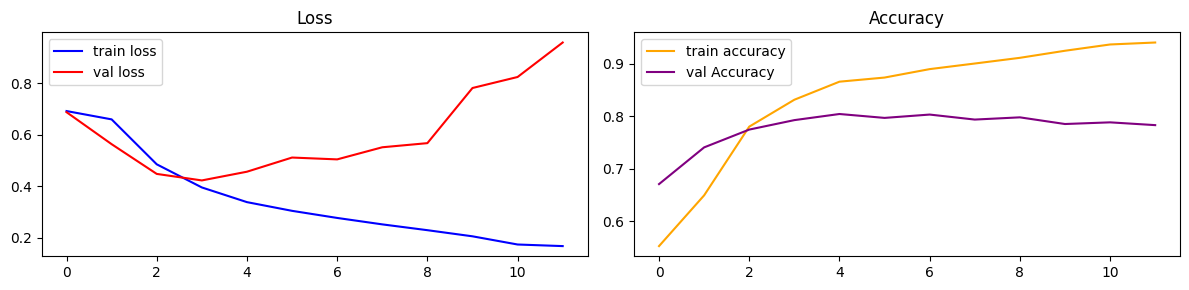

In [60]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
plt.plot(histgru.history['loss'], label='train loss', color= "blue")
plt.plot(histgru.history['val_loss'], label='val loss', color="red")
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(histgru.history['accuracy'], label='train accuracy', color= "orange")
plt.plot(histgru.history['val_accuracy'], label='val Accuracy', color= "purple")
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [209]:
##Save best GRU model

model_path3= work_dir+'/gru_bestmod.h5'
loadmod3= load_model(model_path3)
val_loss3, val_acc3 = loadmod3.evaluate(X_val_vect, y_val)
print("Val Accuracy of Best Model=", val_acc3)
acc.append(round(val_acc3,4))
loss.append(round(val_loss3,4))

30/30 [==============================] - 1s 15ms/step - loss: 0.4230 - accuracy: 0.7926
Val Accuracy of Best Model= 0.7925925850868225


In [210]:
acc

[0.805, 0.8042, 0.7926]

In [211]:
loss

[0.461, 0.4366, 0.423]

## Hyperparameter tuning and building upon LSTM model

After testing out many different hyperparameter values including changes in batch size, several layers and filter sizes, different optimizers and learning rates, the below model architecture is an improvement over the intial LSTM model.

Along with the below layers from the orginal model architectures....

1. An Embedding layer for creating word embeddings. The integer-encoded vocabulary is transformed into a dense vector of output_dim.
2. An LSTM with 128 units and an activation "relu"
3. A drop out layer of 0.5 for regularization. This is used to reduce overfitting but randonly selecting a portion of input units and set it to 0 for training and introducing noise.
4. A dense layer of 1 unit for binary class probability predictions

This model architecture includes the additional following:

1. Decrease embedding dim size for reducing model complexity
2. Increase word size from 4000 to 10000 to capture larger relationships
2. Bidirectional layers to process data forward and backwards. Includes 128 units and 64 units. Captures information in both directions.
3. Includes a dropout layer after the second Bidirectinoal layer. This is important because it helps to reduce overfitting by randomly dropping neurons and by preventing neurons from relying to much on eachother, forcing network to learn more robust features of the data.
4. Batch normalization layer is also included as a regularization technique to improve the traiing speed and stability of the neural networks at each layer.
5. Remove dense layer 128.

In [202]:
##model tuned
embedding_dim = 64
vocab_size= 10000
max_len= 30

model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, 
                     output_dim=embedding_dim, 
                     input_length=max_len))
# model3.add(Embedding(input_dim= 20000, 
#                      output_dim= 128, 
#                      input_length= max_len))
model3.add(Bidirectional(LSTM(units=128, activation='relu', return_sequences=True)))
model3.add(Dropout(0.5))
model3.add(Bidirectional(LSTM(units=64, activation='relu')))
model3.add(Dropout(0.5))
# model3.add(Bidirectional(LSTM(units=50, activation='relu')))
# model3.add(Dropout(0.5))
## batch norm for stability
model3.add(BatchNormalization())  
# model3.add(Flatten())
# model3.add(Dense(units=128, activation='relu'))
model3.add(Dense(units=1, activation='sigmoid'))

## compile and add gradient clipping
optimizer = Adam(learning_rate=0.0001, clipvalue=0.5)
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

##model3 summary
model3.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 30, 64)            640000    
                                                                 
 bidirectional_77 (Bidirecti  (None, 30, 256)          197632    
 onal)                                                           
                                                                 
 dropout_78 (Dropout)        (None, 30, 256)           0         
                                                                 
 bidirectional_78 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_79 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_38 (Bat  (None, 128)            

In [203]:
early_stop3 = EarlyStopping(monitor='val_loss', 
                           patience=6, 
                           restore_best_weights=True)
model_cp3 = ModelCheckpoint("tuned_bestmod.h5",
                           monitor= 'val_loss',
                           verbose= 1,
                           save_best_only=True)
reduce_lr3 = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=4, 
                              min_lr=0.00001)

In [204]:
num_eps = 20
# batches= 64
batches= 32

##Model train
modhist3 = model3.fit(X_train_vect, 
                       y_train, 
                       batch_size= batches, 
                       epochs= num_eps, 
                       callbacks=[early_stop3, model_cp3, reduce_lr3],
                       validation_data=(X_val_vect, y_val))

Epoch 1/20
168/168 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5283
Epoch 1: val_loss improved from inf to 0.68997, saving model to tuned_bestmod.h5
168/168 [==============================] - 56s 304ms/step - loss: 0.6896 - accuracy: 0.5283 - val_loss: 0.6900 - val_accuracy: 0.6466 - lr: 1.0000e-04
Epoch 2/20
168/168 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.6458
Epoch 2: val_loss improved from 0.68997 to 0.64991, saving model to tuned_bestmod.h5
168/168 [==============================] - 50s 296ms/step - loss: 0.6335 - accuracy: 0.6458 - val_loss: 0.6499 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 3/20
168/168 [==============================] - ETA: 0s - loss: 0.4514 - accuracy: 0.7970
Epoch 3: val_loss improved from 0.64991 to 0.46784, saving model to tuned_bestmod.h5
168/168 [==============================] - 50s 296ms/step - loss: 0.4514 - accuracy: 0.7970 - val_loss: 0.4678 - val_accuracy: 0.7968 - lr: 1.0000e-04
Epoch 4/

### Tuned Model Evaluation

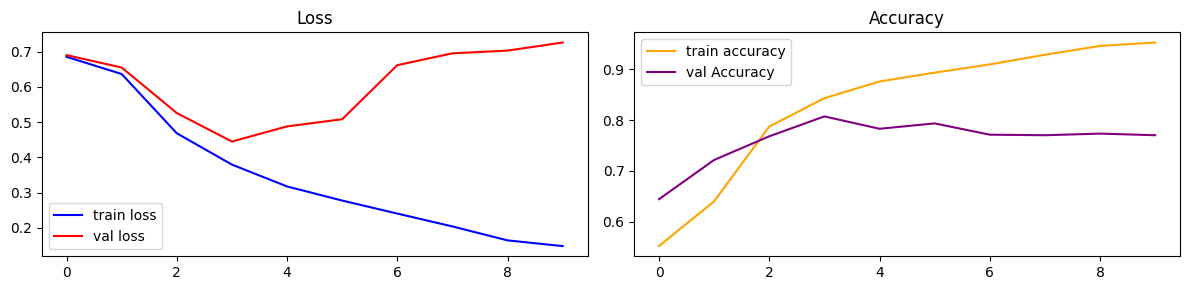

In [170]:
# Plotting training and validation loss and accuracy for model 2
plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
plt.plot(modhist3.history['loss'], label='train loss', color= "blue")
plt.plot(modhist3.history['val_loss'], label='val loss', color="red")
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(modhist3.history['accuracy'], label='train accuracy', color= "orange")
plt.plot(modhist3.history['val_accuracy'], label='val Accuracy', color= "purple")
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [212]:
##Save best Tuned model

model_path4= work_dir+'/tuned_bestmod.h5'
loadmod4= load_model(model_path4)
val_loss4, val_acc4 = loadmod4.evaluate(X_val_vect, y_val)
print("Val Accuracy of Best Model=", val_acc4)
acc.append(round(val_acc4,4))
loss.append(round(val_loss4,4))

30/30 [==============================] - 2s 46ms/step - loss: 0.4320 - accuracy: 0.8032
Val Accuracy of Best Model= 0.803174614906311


In [213]:
acc

[0.805, 0.8042, 0.7926, 0.8032]

In [214]:
loss

[0.461, 0.4366, 0.423, 0.432]

Now let's view the overall performance

In [215]:
overall_df = pd.DataFrame({'model': ['DistilBERT', 'LSTM', 'GRU', 'Tuned LSTM'],
                   'accuracy': acc,
                   'loss': loss})

(0.3, 0.5)

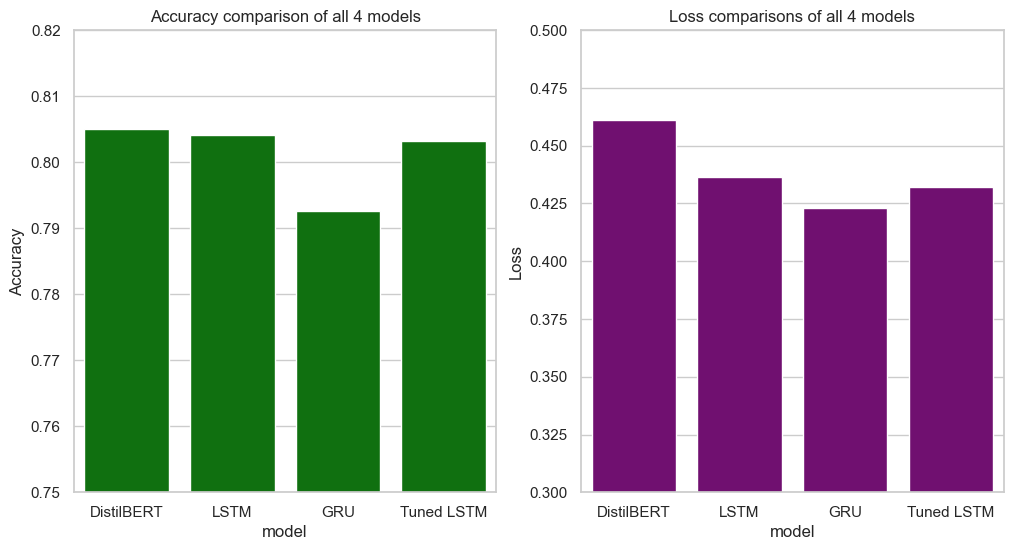

In [219]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

##accuracy
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x='model', y='accuracy', data=overall_df, color='green')
ax1.set_title('Accuracy comparison of all 4 models')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.75, 0.82)
#loss
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='model', y='loss', data=overall_df, color='purple')
ax2.set_title('Loss comparisons of all 4 models')
ax2.set_ylabel('Loss')
ax2.set_ylim(0.3, 0.50)

All models perform similarly well with the tuned model showing less loss and very close accuracy to the less complex model. We will try predicting test set with both LSTM models to see what our final performance is.

## Predict on Test Dataset for Submission

Finally we will use our best model to predict the testing clasess: 0 for no cancer tumor detected, and 1 for cancerous tumor.

In [175]:
##prep test_df
test_df.head()

,id,keyword,location,text,comb_text,text_len,full_text
0,0,,NaN,Just happened a terrible car crash,Just happened a terrible car crash,35,"[happened, terrible, car, crash]"
1,2,,NaN,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s...",65,"[heard, earthquake, different, cities, stay, s..."
2,3,,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...",97,"[forest, fire, spot, pond, geese, fleeing, acr..."
3,9,,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires,41,"[apocalypse, lighting, spokane, wildfires]"
4,11,,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,46,"[typhoon, soudelor, kills, china, taiwan]"


In [187]:
##Load top modell=
# load_model('bestmodel.h5')
model_path= work_dir+'/lstm_bestmod.h5'
loadmod= load_model(model_path)

In [188]:
#run model to find predictions
preds = loadmod.predict(X_test_vect)

102/102 [==============================] - 2s 13ms/step


In [189]:
preds = np.transpose(preds)[0]
sub_df = pd.DataFrame({
    'id': test_df['id'],#
    'target': (preds > 0.5).astype(int)
})

##View submission dataframe
sub_df.head(7)

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
5,12,0
6,21,0


In [190]:
#view test prediction counts
sub_df['target'].value_counts()

target
0    1976
1    1287
Name: count, dtype: int64

[Text(0, 0, 'Non_disaster'), Text(1, 0, 'Disaster')]

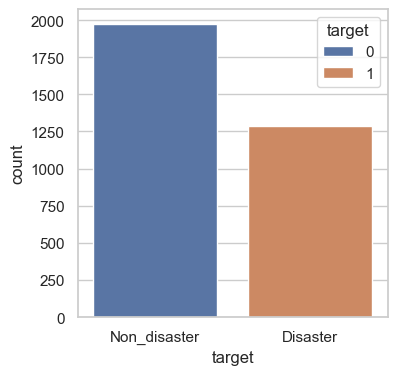

In [191]:
##View plot
plt.figure(figsize=(4, 4))
smplot = sns.countplot(x='target', hue='target', data= sub_df, palette="deep")
smplot.set_xticks([0, 1])
smplot.set_xticklabels(['Non_disaster','Disaster'])


Now compare it to the length of the sample submission to see if it is of appropriate submission length

In [192]:
len(samp_df)

3263

In [193]:
len(sub_df)==len(samp_df)

True

In [194]:
#convert to csv and submit to get score
sub_df.to_csv('nlp_submission2.csv', index=False)

## Discussion/Conclusion

After exploring our natural distater tweet dataset, conducting EDA adn processing the data, we've ran the dataset in 4 deep learning model architecures.

The first model architecture we used was the distilBERT model. Despite using only 2000 total data rows and 80% of that was for text processing and and the training set, we achieved a validation loss of 0.4610 and accuracy fo 0.8050 which is quite good.

The LSTM model worked better in terms of having less loss than distilhibert but slightly less validation accuracy. 

The GRU model showed even less validation loss but slightly lower accuracy although the numbers were still relatively low.

Out final tuned LSTM model was an improvement in validation loss over the basic LSTM model with equivalent accuracy.

Through many different iterations and time spent to come up with a model that can generalize well to unseen data, we achieved a current score of 0.788. This indicates that there is much more room for improving upon the model! We can try to improve our model performance quite a number of ways:

1. Shuffling and and performing different poprotions of training and validation splits for our dataset. 
2. Utilize different forms of tokenization such as word, sub word or character tokenization
3. Test out different methods of text processing and word vectorization such as bagging of words (BOW) and N-grams.
4. Hyperparameter tuning such as grid searching batch sizes, different number and types of layers, different learning rates and optimizers

Also comparing theese deep learning models to other machine learning models such as logistic regression, naive bayes or decision trees would be ideal to see which yields better predictinons on unseen datasets. Not only do some of these models have less hyperparameter tuning, some of these models require less computational resources to train as well making them probably an effienct alternative for our text classification and prediction problem.
